# Model Loading

In [1]:
import os
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
import argparse
import logging
from datetime import datetime, timedelta, date
import torch
import torch.nn.functional as F
import sklearn.metrics as metrics
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from torch_geometric.utils.convert import from_networkx

In [2]:
from networks_pyg.GCN import *
from datasets.Myloader import traffic_mtsc_loader
# from optim import Mytrainer
# from optim.loss import loss_function,init_center
# from datasets import dataloader_pyg as dataloader
# from datasets import Myloader
from networks_pyg.init import init_model
from optim.loss_my import anomaly_score

from sklearn.metrics import *

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
parser = argparse.ArgumentParser(description='OCGNN')
parser.add_argument("--dataset", type=str, default='cora',
        help="dataset")
parser.add_argument("--dropout", type=float, default=0.25,
        help="dropout probability")
parser.add_argument("--nu", type=float, default=0.01, # 0.2
        help="hyperparameter nu (must be 0 < nu <= 1)")
parser.add_argument("--gpu", type=int, default=0,
        help="gpu")
parser.add_argument("--seed", type=int, default=52,
        help="random seed, -1 means dont fix seed")
parser.add_argument("--module", type=str, default='GraphSAGE',
        help="GCN/GAT/GIN/GraphSAGE/GAE")
parser.add_argument('--n-worker', type=int,default=1,
        help='number of workers when dataloading')
parser.add_argument('--batch-size', type=int,default=128,
        help='batch size')
parser.add_argument("--lr", type=float, default=1e-3,
        help="learning rate")
parser.add_argument("--n-epochs", type=int, default=100,
        help="number of training epochs")
parser.add_argument("--n-hidden", type=int, default=32,
        help="number of hidden gnn units")
parser.add_argument("--n-layers", type=int, default=2,
        help="number of hidden gnn layers")
parser.add_argument("--weight-decay", type=float, default=5e-4,
        help="Weight for L2 loss")
parser.add_argument('--early-stop', action='store_true', default=False,
                    help="indicates whether to use early stop or not")
parser.add_argument("--self-loop", action='store_true',
        help="graph self-loop (default=False)")
parser.add_argument("--norm", action='store_true',
        help="graph normalization (default=False)")
parser.add_argument("--reverse", default=False,
        help='Reverse of the adjacency matrix')
parser.add_argument("--exp-name", default='test',
        help='exp name to save model and log')
parser.set_defaults(self_loop=True)
parser.set_defaults(norm=False)
# args = parser.parse_args()
args = parser.parse_args(args=[])
# if args.module=='GCN':
#     #args.self_loop=True
#     args.norm=True
# if args.module=='GAE':
#     args.lr=0.002
#     args.dropout=0.
#     args.weight_decay=0.
#     # args.n_hidden=32
# #     args.self_loop=True
# # if args.module=='GraphSAGE':
# #     args.self_loop=True


In [5]:
# Data Loading
data_root_path = '/media/usr/HDD/Data/NAVER'
partition_list = os.listdir(data_root_path)
partition_list = [p for p in partition_list if p[0]=='2']
partition_list = np.sort(partition_list)

data_path = '/media/usr/HDD/Working/Naver_Data/data_parsing'



## load accident_all
accident_all = pd.read_csv('../data/accident_all.csv', index_col=0)
print("# of filtered Events = ", len(accident_all))


# Profile Extraction Functions
def profile_extraction2(speed_all):
    # Day of Week => monday : 0, sunday : 6
    speed_all['weekday'] = [s.weekday() for s in speed_all.index]
    speed_all['timestamp'] = [s.time() for s in speed_all.index]
    
    profile_mean = speed_all.groupby(['weekday', 'timestamp']).mean()
    profile_std = speed_all.groupby(['weekday', 'timestamp']).std()
    
    speed_all = speed_all.drop(['weekday', 'timestamp'], axis=1)
    
    return speed_all, profile_mean, profile_std

# of filtered Events =  849


In [6]:
## https://github.com/mangushev/mtad-tf/blob/main/evaluate.py
#just like onmianomaly, no delta. If we hit anuthing in anomaly interval, whole anomaly segment is correctly identified
#-----------------------
#1|0|1|1|1|0|0|0|1|1|1|1  Labels
#-----------------------
#0|0|0|1|1|0|0|0|0|0|1|0  Predictions
#-----------------------
#0|0|1|1|1|0|0|0|1|1|1|1  Adjusted
#-----------------------
def adjust_predictions(predictions, labels):
  adjustment_started = False
  new_pred = predictions

  for i in range(len(predictions)):
    if labels[i] == 1:
      if predictions[i] == 1:
        if not adjustment_started:
          adjustment_started = True
          for j in range(i, 0, -1):
            if labels[j] == 1:
              new_pred[j] = 1
            else:
              break
    else:
      adjustment_started = False

    if adjustment_started:
      new_pred[i] = 1
      
  return new_pred

In [7]:
def evaluate(true, pred, score, adjust = False, plot=False, print_=False):
#     true = label_all
#     pred = list(map(int, [s>0 for s in score_all]))
    if adjust:
        pred = adjust_predictions(pred, true)
    CM = confusion_matrix(true, pred)
    TN = CM[0][0]
    FN = CM[1][0]
    TP = CM[1][1]
    FP = CM[0][1]
    acc = accuracy_score(true, pred)
    # auc = roc_auc_score(true, pred)
    auc = roc_auc_score(true, score)
#     far = FP / (FP+TN)
    far = FP / (TP+FP)
    pre = precision_score(true, pred, pos_label=1)
    rec = recall_score(true, pred, pos_label=1)
    macro_f1 = f1_score(true, pred, average='macro')
    weighted_f1 = f1_score(true, pred, average='weighted')
    ap = average_precision_score(true, score)
    # ap = average_precision_score(true, pred)
    if plot:
        plt.figure(figsize=(40, 5))
        plt.plot(true)
        plt.plot(pred)
    if print_:
        print('Accuracy \t{:.4f}'.format(acc))
        print('AUC score \t{:.4f}'.format(auc))
        print('FAR score \t{:.4f}'.format(far))
        print('Precision \t{:.4f}'.format(pre))
        print('Recall   \t{:.4f}'.format(rec))
        print('Macro F1 \t{:.4f}'.format(macro_f1))
        print('weighted F1 \t{:.4f}'.format(weighted_f1))
        print('Avg Precision \t{:.4f}'.format(ap))
        print(classification_report(true, pred))
    return [acc, auc, far, pre, rec, macro_f1, weighted_f1, ap]

# Dataset Loading

### Anomaly Ratio Check

In [8]:
for target_sid in ['1210005301', '1030001902', '1220005401', '1210003000', '1130052300']:
    args.dataset = '{}_mprofile'.format(target_sid)
    print(args.dataset)
    train_loader, val_loader, test_loader = traffic_mtsc_loader(args)

    y_all = []
    for data in train_loader:
        y_all.append(data.y)
    y_all = torch.concat(y_all).unique(return_counts=True)
    train_ratio = y_all[1][1] / y_all[1].sum()
    print(y_all[1])

    y_all = []
    for data in val_loader:
        y_all.append(data.y)
    y_all = torch.concat(y_all).unique(return_counts=True)
    if len(y_all[1]) == 1:
        val_ratio = 0
    else:
        val_ratio = y_all[1][1] / y_all[1].sum()
    print(y_all[1])
    
    y_all = []
    for data in test_loader:
        y_all.append(data.y)
    y_all = torch.concat(y_all).unique(return_counts=True)
    if len(y_all[1]) == 1:
        test_ratio = 0
    else:
        test_ratio = y_all[1][1] / y_all[1].sum()
    print(y_all[1])

    print(train_ratio, val_ratio, test_ratio)



1210005301_mprofile
train dataset


  0%|          | 0/7485 [00:00<?, ?it/s]/home/jiin/anaconda3/envs/AID/lib/python3.10/site-packages/torch_geometric/utils/convert.py:249: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  data[key] = torch.tensor(value)
100%|██████████| 7485/7485 [00:02<00:00, 3567.83it/s]


val dataset


100%|██████████| 2269/2269 [00:00<00:00, 3606.11it/s]


test dataset


100%|██████████| 2051/2051 [00:00<00:00, 3685.39it/s]


tensor([7441,   44])
tensor([2171,   98])
tensor([1924,  127])
tensor(0.0059) tensor(0.0432) tensor(0.0619)
1030001902_mprofile
train dataset


100%|██████████| 6099/6099 [00:01<00:00, 3599.47it/s]


val dataset


100%|██████████| 1480/1480 [00:00<00:00, 3791.60it/s]


test dataset


100%|██████████| 1749/1749 [00:00<00:00, 4076.43it/s]


tensor([6014,   85])
tensor([1362,  118])
tensor([1606,  143])
tensor(0.0139) tensor(0.0797) tensor(0.0818)
1220005401_mprofile
train dataset


100%|██████████| 10560/10560 [00:02<00:00, 3819.00it/s]


val dataset


100%|██████████| 2785/2785 [00:00<00:00, 4147.02it/s]


test dataset


100%|██████████| 2565/2565 [00:00<00:00, 3149.92it/s]


tensor([10490,    70])
tensor([2719,   66])
tensor([2487,   78])
tensor(0.0066) tensor(0.0237) tensor(0.0304)
1210003000_mprofile
train dataset


100%|██████████| 7608/7608 [00:01<00:00, 4534.16it/s]


val dataset


100%|██████████| 1852/1852 [00:00<00:00, 4425.11it/s]


test dataset


100%|██████████| 1274/1274 [00:00<00:00, 4292.92it/s]


tensor([7480,  128])
tensor([1852])
tensor([1228,   46])
tensor(0.0168) 0 tensor(0.0361)
1130052300_mprofile
train dataset


100%|██████████| 2459/2459 [00:00<00:00, 2982.05it/s]


val dataset


100%|██████████| 1030/1030 [00:00<00:00, 3998.15it/s]


test dataset


100%|██████████| 825/825 [00:00<00:00, 3980.50it/s]


tensor([2432,   27])
tensor([992,  38])
tensor([769,  56])
tensor(0.0110) tensor(0.0369) tensor(0.0679)


# All Results

In [9]:
## load accident_all
accident_all = pd.read_csv('../data/accident_all.csv', index_col=0)
accident_all['created'] = pd.to_datetime(accident_all['created'])
print("# of filtered Events = ", len(accident_all))

# of filtered Events =  849


In [10]:
accident_all['accident_sid'].value_counts()

1210005301    20
1030001902    19
1220005401    15
1210003000    13
1130052300    12
              ..
2210066900     1
1120013402     1
1100005401     1
1070010402     1
1040020100     1
Name: accident_sid, Length: 482, dtype: int64

In [23]:
result_all = []
target_sid = 1210005301 ## 1210005301  ## 1030001902  ## 1220005401  ## 1210003000  ## 1130052300
accident_case = accident_all[accident_all.loc[:, 'accident_sid'] == target_sid]
eventID = accident_case.eventId.iloc[0]

args.gpu = 0

for normalize in ['standard']:
    # data
    args.dataset = '{}_mprofile'.format(target_sid)
    args.normalize = normalize
    args.bias = True
#     df_all_norm, label_df, H = preprocessing(eventID, normalize)
    train_loader, val_loader, test_loader = traffic_mtsc_loader(args)
    print(len(train_loader), len(val_loader), len(test_loader))

    for nu in [0.01, 0.05, 0.1, 0.2, 0.3]:
        # for module in ['GCN_gc', 'GCN_traffic', 'GraphSAGE_gc']:
        for name, module in zip(['GCN', 'GAT', 'GraphSAGE', 'STGCN',], ['GCN_gc','GAT_gc', 'GraphSAGE_gc', 'STGCN']):
            args.module=module
            args.nu = nu
            args.self_loop = 'True'
            args.pooling = 'sum'

            args.exp_name = f'{args.dataset}_{name}_{args.pooling}_{args.nu}_{args.self_loop}'


            checkpoints_path=f'./checkpoints_SAD_mprofile/{args.dataset}/{args.exp_name}+bestcheckpoint.pt'
            print("##############################")
            print(checkpoints_path)
            # print(args)

            # model
            input_dim = 24
            model = init_model(args, input_dim)
            model.to(device='cuda:0')
            model.load_state_dict(torch.load(checkpoints_path)['model'])
            model.to(device=f'cuda:{args.gpu}')
            model.eval()
            data_center = torch.load(checkpoints_path)['data_center'].to(device=f'cuda:{args.gpu}')
            radius = torch.load(checkpoints_path)['radius'].to(device=f'cuda:{args.gpu}')

            out_all, dist_all, score_all = [], [], []
            for ix, data in tqdm(enumerate(val_loader)):
                output = model(data.to(device=f'cuda:{args.gpu}'))
                out_all.append(output.cpu().detach().numpy())
                dist, _ = anomaly_score(data_center, output, radius)
                dist_all.append(dist.cpu().detach().numpy())
                # score_all.append(score.cpu().detach().numpy())
            dist_all = np.concatenate(dist_all)
            new_radius = np.quantile(np.sqrt(dist_all), 1 - args.nu)
            print(radius.data, new_radius)


            out_all, dist_all, score_all = [], [], []
            label_all = []
            for ix, data in tqdm(enumerate(test_loader)):
                output = model(data.to(device=f'cuda:{args.gpu}'))
                out_all.append(output.cpu().detach().numpy())
                label_all.append(data.y.cpu().detach().numpy())
                dist, score = anomaly_score(data_center, output, new_radius) # new_radius
                dist_all.append(dist.cpu().detach().numpy())
                score_all.append(score.cpu().detach().numpy())
            label_all = np.concatenate(label_all)
            score_all = np.concatenate(score_all)
            dist_all = np.concatenate(dist_all)

            pred = (score_all > 0).astype(int)

            acc, auc, far, pre, rec, macro_f1, weight_f1, ap = evaluate(label_all, pred, score_all, adjust=False, plot=False)
            result_all.append([name, args.normalize, args.nu, False, rec, far, pre, rec, acc, auc, macro_f1, weight_f1, ap])
            acc, auc, far, pre, rec, macro_f1, weight_f1, ap = evaluate(label_all, pred, score_all, adjust=True, plot=False)
            result_all.append([name, args.normalize, args.nu, True, rec, far, pre, rec, acc, auc, macro_f1, weight_f1, ap])

train dataset


100%|██████████| 7608/7608 [00:01<00:00, 4232.39it/s]


val dataset


100%|██████████| 1852/1852 [00:00<00:00, 5063.69it/s]


test dataset


100%|██████████| 1274/1274 [00:00<00:00, 4653.45it/s]


60 15 10
##############################
./checkpoints_SAD_mprofile/1210003000_mprofile/1210003000_mprofile_GCN_sum_0.01_True+bestcheckpoint.pt
Parameter number of GCN_gc Net is: 7840


15it [00:00, 107.04it/s]


tensor(3.4648, device='cuda:0', dtype=torch.float64) 4.96559150695801


10it [00:00, 102.80it/s]


##############################
./checkpoints_SAD_mprofile/1210003000_mprofile/1210003000_mprofile_GAT_sum_0.01_True+bestcheckpoint.pt
Parameter number of GAT_gc Net is: 293984


15it [00:00, 86.22it/s]


tensor(2.2749, device='cuda:0', dtype=torch.float64) 2.693686008453369


10it [00:00, 94.25it/s]


##############################
./checkpoints_SAD_mprofile/1210003000_mprofile/1210003000_mprofile_GraphSAGE_sum_0.01_True+bestcheckpoint.pt
Parameter number of GraphSAGE_gc Net is: 15520


15it [00:00, 129.70it/s]


tensor(1.8382, device='cuda:0', dtype=torch.float64) 4.490530738830566


10it [00:00, 131.54it/s]


##############################
./checkpoints_SAD_mprofile/1210003000_mprofile/1210003000_mprofile_STGCN_sum_0.01_True+bestcheckpoint.pt
Parameter number of STGCN Net is: 4532


15it [00:00, 19.92it/s]


tensor(0.1473, device='cuda:0', dtype=torch.float64) 0.2356997899711132


10it [00:00, 18.14it/s]


##############################
./checkpoints_SAD_mprofile/1210003000_mprofile/1210003000_mprofile_GCN_sum_0.05_True+bestcheckpoint.pt
Parameter number of GCN_gc Net is: 7840


15it [00:00, 99.62it/s]


tensor(1.9025, device='cuda:0', dtype=torch.float64) 2.4065425038337707


10it [00:00, 81.38it/s]


##############################
./checkpoints_SAD_mprofile/1210003000_mprofile/1210003000_mprofile_GAT_sum_0.05_True+bestcheckpoint.pt
Parameter number of GAT_gc Net is: 293984


15it [00:00, 91.34it/s]


tensor(1.8871, device='cuda:0', dtype=torch.float64) 1.8526280403137205


10it [00:00, 90.10it/s]


##############################
./checkpoints_SAD_mprofile/1210003000_mprofile/1210003000_mprofile_GraphSAGE_sum_0.05_True+bestcheckpoint.pt
Parameter number of GraphSAGE_gc Net is: 15520


15it [00:00, 108.57it/s]


tensor(1.1722, device='cuda:0', dtype=torch.float64) 3.225155985355376


10it [00:00, 115.28it/s]


##############################
./checkpoints_SAD_mprofile/1210003000_mprofile/1210003000_mprofile_STGCN_sum_0.05_True+bestcheckpoint.pt
Parameter number of STGCN Net is: 4532


15it [00:00, 18.79it/s]


tensor(0.6119, device='cuda:0', dtype=torch.float64) 0.638698273897171


10it [00:00, 19.56it/s]


##############################
./checkpoints_SAD_mprofile/1210003000_mprofile/1210003000_mprofile_GCN_sum_0.1_True+bestcheckpoint.pt
Parameter number of GCN_gc Net is: 7840


15it [00:00, 100.90it/s]


tensor(2.3189, device='cuda:0', dtype=torch.float64) 2.5370250701904298


10it [00:00, 93.67it/s]


##############################
./checkpoints_SAD_mprofile/1210003000_mprofile/1210003000_mprofile_GAT_sum_0.1_True+bestcheckpoint.pt
Parameter number of GAT_gc Net is: 293984


15it [00:00, 96.78it/s]


tensor(1.4773, device='cuda:0', dtype=torch.float64) 1.4553734183311462


10it [00:00, 85.09it/s]


##############################
./checkpoints_SAD_mprofile/1210003000_mprofile/1210003000_mprofile_GraphSAGE_sum_0.1_True+bestcheckpoint.pt
Parameter number of GraphSAGE_gc Net is: 15520


15it [00:00, 107.55it/s]


tensor(0.9118, device='cuda:0', dtype=torch.float64) 3.081734275817871


10it [00:00, 122.14it/s]


##############################
./checkpoints_SAD_mprofile/1210003000_mprofile/1210003000_mprofile_STGCN_sum_0.1_True+bestcheckpoint.pt
Parameter number of STGCN Net is: 4532


15it [00:00, 19.49it/s]


tensor(0.6109, device='cuda:0', dtype=torch.float64) 0.637778514623642


10it [00:00, 18.39it/s]


##############################
./checkpoints_SAD_mprofile/1210003000_mprofile/1210003000_mprofile_GCN_sum_0.2_True+bestcheckpoint.pt
Parameter number of GCN_gc Net is: 7840


15it [00:00, 103.35it/s]


tensor(2.5474, device='cuda:0', dtype=torch.float64) 2.9932998657226566


10it [00:00, 101.48it/s]


##############################
./checkpoints_SAD_mprofile/1210003000_mprofile/1210003000_mprofile_GAT_sum_0.2_True+bestcheckpoint.pt
Parameter number of GAT_gc Net is: 293984


15it [00:00, 89.91it/s]


tensor(1.5488, device='cuda:0', dtype=torch.float64) 1.5816365242004395


10it [00:00, 91.59it/s]


##############################
./checkpoints_SAD_mprofile/1210003000_mprofile/1210003000_mprofile_GraphSAGE_sum_0.2_True+bestcheckpoint.pt
Parameter number of GraphSAGE_gc Net is: 15520


15it [00:00, 104.46it/s]


tensor(1.4176, device='cuda:0', dtype=torch.float64) 3.311488151550293


10it [00:00, 113.68it/s]


##############################
./checkpoints_SAD_mprofile/1210003000_mprofile/1210003000_mprofile_STGCN_sum_0.2_True+bestcheckpoint.pt
Parameter number of STGCN Net is: 4532


15it [00:00, 18.83it/s]


tensor(0.6101, device='cuda:0', dtype=torch.float64) 0.6371628642082214


10it [00:00, 19.66it/s]


##############################
./checkpoints_SAD_mprofile/1210003000_mprofile/1210003000_mprofile_GCN_sum_0.3_True+bestcheckpoint.pt
Parameter number of GCN_gc Net is: 7840


15it [00:00, 111.34it/s]


tensor(1.7340, device='cuda:0', dtype=torch.float64) 2.078268265724182


10it [00:00, 112.92it/s]


##############################
./checkpoints_SAD_mprofile/1210003000_mprofile/1210003000_mprofile_GAT_sum_0.3_True+bestcheckpoint.pt
Parameter number of GAT_gc Net is: 293984


15it [00:00, 84.28it/s]


tensor(1.2841, device='cuda:0', dtype=torch.float64) 1.1013058066368102


10it [00:00, 100.96it/s]


##############################
./checkpoints_SAD_mprofile/1210003000_mprofile/1210003000_mprofile_GraphSAGE_sum_0.3_True+bestcheckpoint.pt
Parameter number of GraphSAGE_gc Net is: 15520


15it [00:00, 119.96it/s]


tensor(1.1585, device='cuda:0', dtype=torch.float64) 2.2142981052398683


10it [00:00, 89.83it/s]


##############################
./checkpoints_SAD_mprofile/1210003000_mprofile/1210003000_mprofile_STGCN_sum_0.3_True+bestcheckpoint.pt
Parameter number of STGCN Net is: 4532


15it [00:00, 18.80it/s]


tensor(0.6089, device='cuda:0', dtype=torch.float64) 0.6369043946266174


10it [00:00, 20.23it/s]


In [24]:
result_all = pd.DataFrame(result_all, columns=['model', 'normalize', 'nu', 'adjust', 'DR', 'far', 'precision', 'recall', 'acc', 'AUC', 'F1_macro', 'F1_weight', 'AP'])
result_all

,model,normalize,nu,adjust,DR,far,precision,recall,acc,AUC,F1_macro,F1_weight,AP
0,GCN,standard,0.01,False,0.000000,1.000000,0.000000,0.000000,0.910518,0.506302,0.476582,0.918748,0.038353
1,GCN,standard,0.01,True,0.000000,1.000000,0.000000,0.000000,0.910518,0.506302,0.476582,0.918748,0.038353
2,GAT,standard,0.01,False,0.000000,1.000000,0.000000,0.000000,0.929356,0.432021,0.481692,0.928600,0.029499
3,GAT,standard,0.01,True,0.000000,1.000000,0.000000,0.000000,0.929356,0.432021,0.481692,0.928600,0.029499
4,GraphSAGE,standard,0.01,False,0.021739,0.988764,0.011236,0.021739,0.895604,0.370380,0.479848,0.911300,0.030812
5,GraphSAGE,standard,0.01,True,0.782609,0.709677,0.290323,0.782609,0.923077,0.370380,0.691159,0.939462,0.030812
6,STGCN,standard,0.01,False,0.021739,0.000000,1.000000,0.021739,0.964678,0.604146,0.512280,0.948087,0.190763
7,STGCN,standard,0.01,True,0.782609,0.000000,1.000000,0.782609,0.992151,0.604146,0.936997,0.991688,0.190763
8,GCN,standard,0.05,False,0.086957,0.959184,0.040816,0.086957,0.893250,0.641552,0.499492,0.911369,0.052191
9,GCN,standard,0.05,True,0.782609,0.723077,0.276923,0.782609,0.918367,0.641552,0.682623,0.936402,0.052191


In [25]:
result_all[(result_all.adjust==False)]

,model,normalize,nu,adjust,DR,far,precision,recall,acc,AUC,F1_macro,F1_weight,AP
0,GCN,standard,0.01,False,0.000000,1.000000,0.000000,0.000000,0.910518,0.506302,0.476582,0.918748,0.038353
2,GAT,standard,0.01,False,0.000000,1.000000,0.000000,0.000000,0.929356,0.432021,0.481692,0.928600,0.029499
4,GraphSAGE,standard,0.01,False,0.021739,0.988764,0.011236,0.021739,0.895604,0.370380,0.479848,0.911300,0.030812
6,STGCN,standard,0.01,False,0.021739,0.000000,1.000000,0.021739,0.964678,0.604146,0.512280,0.948087,0.190763
8,GCN,standard,0.05,False,0.086957,0.959184,0.040816,0.086957,0.893250,0.641552,0.499492,0.911369,0.052191
10,GAT,standard,0.05,False,0.000000,1.000000,0.000000,0.000000,0.859498,0.264817,0.462220,0.891062,0.023149
12,GraphSAGE,standard,0.05,False,0.021739,0.984375,0.015625,0.021739,0.915228,0.281688,0.486942,0.921851,0.028666
14,STGCN,standard,0.05,False,0.239130,0.813559,0.186441,0.239130,0.934851,0.534733,0.587775,0.938711,0.135309
16,GCN,standard,0.10,False,0.086957,0.979487,0.020513,0.086957,0.817111,0.467993,0.466099,0.867742,0.032937
18,GAT,standard,0.10,False,0.304348,0.935780,0.064220,0.304348,0.814757,0.479465,0.501367,0.868126,0.040725


In [26]:
result_all.to_csv('result/{}_sumpool.csv'.format(args.dataset))

# Case Result

In [38]:
target_sid = 1210005301 ## 1210005301 ## 1030001902
accident_case = accident_all[accident_all.loc[:, 'accident_sid'] == target_sid]
eventID = accident_case.eventId.iloc[0]

In [39]:
args.dataset = '{}_mprofile'.format(target_sid)
args.normalize = normalize
args.bias = True

args.module = 'STGCN'
name = 'STGCN'
args.nu = 0.1
args.self_loop = 'True'
args.pooling = 'sum'
args.bias = True
args.exp_name = f'{args.dataset}_{name}_{args.pooling}_{args.nu}_{args.self_loop}'

# train_loader, val_loader, test_loader = traffic_mtsc_loader(args)
# print(len(train_loader), len(val_loader), len(test_loader))

In [40]:
checkpoints_path=f'./checkpoints_SAD_mprofile/{args.dataset}/{args.exp_name}+bestcheckpoint.pt'
checkpoints_path

'./checkpoints_SAD_mprofile/1210005301_mprofile/1210005301_mprofile_STGCN_sum_0.1_True+bestcheckpoint.pt'

In [41]:
input_dim = 24
model = init_model(args, input_dim)
# model_1 = init_model(args, input_dim)
# model_50 = init_model(args, input_dim)
# model_100 = init_model(args, input_dim)

Parameter number of STGCN Net is: 4532


In [42]:
print(checkpoints_path)
model.load_state_dict(torch.load(checkpoints_path, map_location='cuda:0')['model'])
model.to(device=f'cuda:{args.gpu}')
model.eval()
data_center = torch.load(checkpoints_path, map_location='cuda')['data_center']
radius = torch.load(checkpoints_path, map_location='cuda')['radius']
model, data_center, radius

./checkpoints_SAD_mprofile/1210005301_mprofile/1210005301_mprofile_STGCN_sum_0.1_True+bestcheckpoint.pt


(STGCN(
   (stblocks): ModuleList(
     (0): STblock(
       (tmp_conv1): TemporalConvLayer(
         (align): Align(
           (align_conv): Conv2d(1, 1, kernel_size=(1, 1), stride=(1, 1))
         )
         (causal_conv): CausalConv2d(1, 2, kernel_size=(3, 1), stride=(1, 1))
         (sigmoid): Sigmoid()
         (tanh): Tanh()
         (relu): ReLU()
         (leaky_relu): LeakyReLU(negative_slope=0.01)
         (silu): SiLU()
       )
       (graph_conv): GCNConv(1, 2)
       (tmp_conv2): TemporalConvLayer(
         (align): Align(
           (align_conv): Conv2d(2, 4, kernel_size=(1, 1), stride=(1, 1))
         )
         (causal_conv): CausalConv2d(2, 8, kernel_size=(3, 1), stride=(1, 1))
         (sigmoid): Sigmoid()
         (tanh): Tanh()
         (relu): ReLU()
         (leaky_relu): LeakyReLU(negative_slope=0.01)
         (silu): SiLU()
       )
       (relu): ReLU()
       (dropout): Dropout(p=0.25, inplace=False)
     )
     (1): STblock(
       (tmp_conv1): TemporalConv

In [43]:
out_all, dist_all, score_all = [], [], []
label_all = []
for ix, data in tqdm(enumerate(val_loader)):
    output = model(data.to(device=f'cuda:{args.gpu}'))
    out_all.append(output.cpu().detach().numpy())
    label_all.append(data.y.cpu().detach().numpy())
    if ix < 5:
        print(output[1][:2])
    # dist, score = anomaly_score(data_center, output, radius)
    dist = torch.sum((output - data_center) ** 2, dim=1)
    dist_all.append(dist.cpu().detach().numpy())
    # score_all.append(score.cpu().detach().numpy())
# label_all = np.concatenate(label_all)
# score_all = np.concatenate(score_all)
dist_all = np.concatenate(dist_all)
print(dist_all[:5])
# new_radius = np.quantile(np.sqrt(dist_all), 1 - args.nu)
new_radius = np.quantile(np.sqrt(dist_all), 1 - args.nu)
new_radius

0it [00:00, ?it/s]9it [00:00, 41.13it/s]

tensor([-1.4840, -1.5814], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([-1.4508, -1.5218], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([-1.4858, -1.5731], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([-1.4728, -1.5667], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([-1.4467, -1.5261], device='cuda:0', grad_fn=<SliceBackward0>)


18it [00:00, 43.38it/s]

[261.5694  261.58984 259.74075 259.34268 261.29953]


16.174828338623048

In [44]:
out_all, dist_all, score_all = [], [], []
label_all = []
for ix, data in tqdm(enumerate(test_loader)):
    output = model(data.to(device=f'cuda:{args.gpu}'))
    out_all.append(output.cpu().detach().numpy())
    label_all.append(data.y.cpu().detach().numpy())
    dist, score = anomaly_score(data_center, output, new_radius)
    dist_all.append(dist.cpu().detach().numpy())
    score_all.append(score.cpu().detach().numpy())
label_all = np.concatenate(label_all)
score_all = np.concatenate(score_all)
dist_all = np.concatenate(dist_all)

0it [00:00, ?it/s]17it [00:00, 45.42it/s]


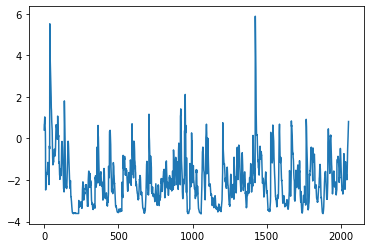

In [45]:
plt.plot(score_all)

Accuracy 	0.9010
AUC score 	0.7095
FAR score 	0.6454
Precision 	0.3546
Recall   	0.3086
Macro F1 	0.6383
weighted F1 	0.8979
Avg Precision 	0.3114
              precision    recall  f1-score   support

           0       0.94      0.95      0.95      1889
           1       0.35      0.31      0.33       162

    accuracy                           0.90      2051
   macro avg       0.65      0.63      0.64      2051
weighted avg       0.90      0.90      0.90      2051



[0.9010238907849829,
 0.7095219889026136,
 0.6453900709219859,
 0.3546099290780142,
 0.30864197530864196,
 0.6382989443982566,
 0.8978675842208403,
 0.31138969388442195]

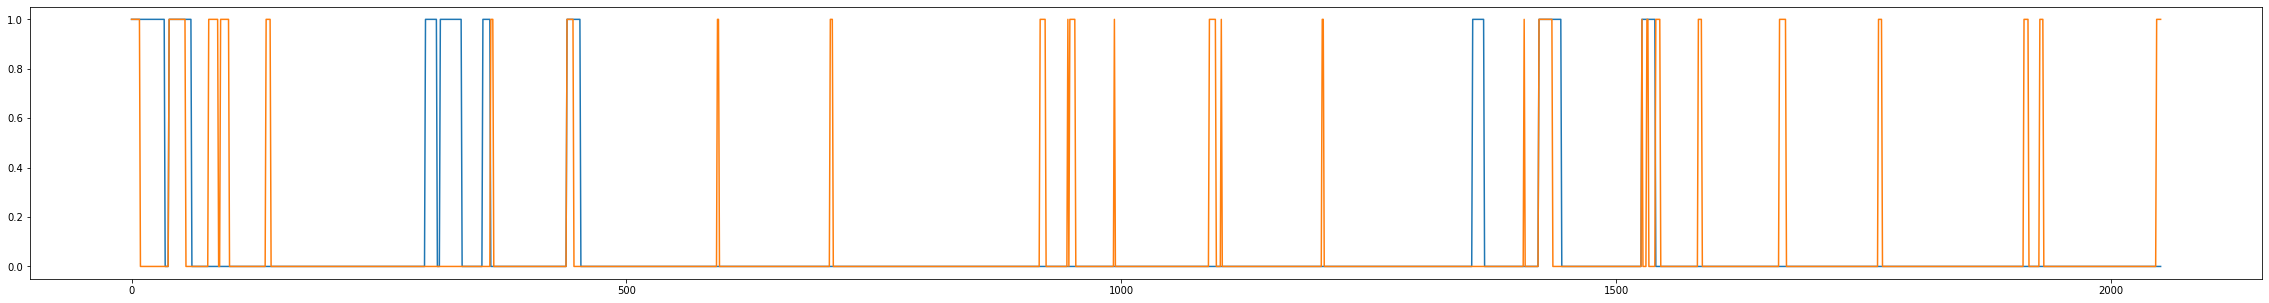

In [46]:
pred = [1 if s > 0 else 0 for s in score_all]
evaluate(label_all, pred, score_all, adjust=False, plot=True, print_=True)

In [74]:
cm = confusion_matrix(label_all, (score_all > 0).astype(int))
cm

array([[1833,   91],
       [  77,   50]])

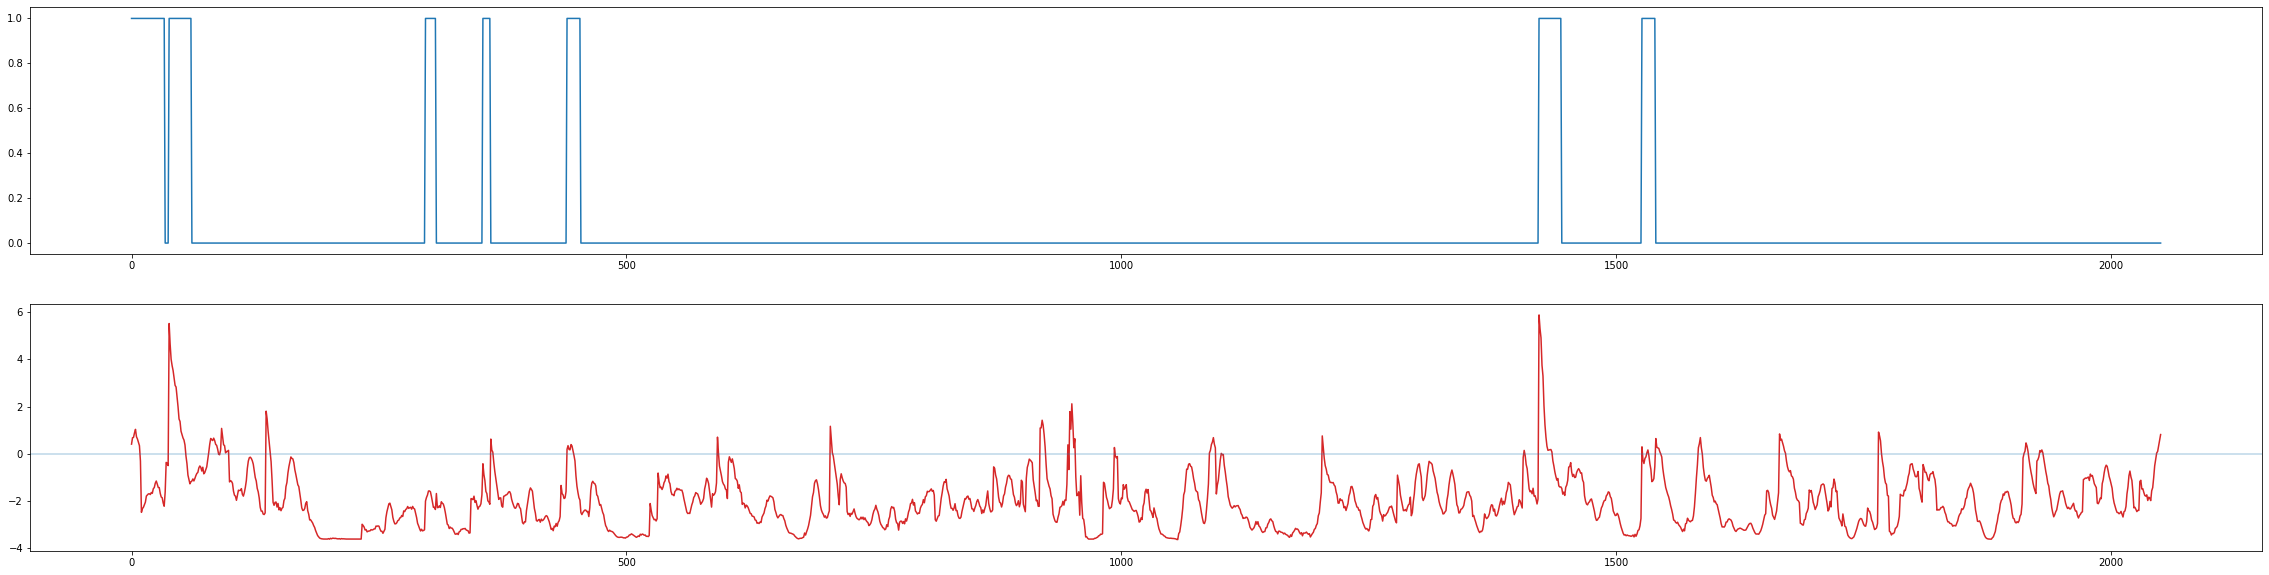

In [75]:
true = label_all
pred = list(map(int, [s>0 for s in score_all]))
plt.figure(figsize=(40, 10))
plt.subplot(2, 1, 1)
plt.plot(true[:4000])
plt.subplot(2, 1, 2)
plt.plot(score_all[:4000], color='tab:red')
# plt.ylim(-0.005, 0.01)
plt.axhline(0, alpha=0.3)


## Case prediction plot

In [76]:
tp = np.where((label_all == 1) & ((score_all > 0).astype(int) == 1))[0]
tmp = np.random.choice(tp, 10)
tmp

array([1435,   45,   38,    6,    4, 1532, 1435, 1433,   40, 1435])

In [77]:
fp = np.where((label_all == 0) & ((score_all > 0).astype(int) == 1))[0]
tmp = np.random.choice(fp, 10)
tmp

array([  82, 1089,   83, 1930, 1543, 1671,  364,  708,  363,  922])

In [78]:
tn = np.where((label_all == 0) & ((score_all > 0).astype(int) == 0))[0]
tmp = np.random.choice(tn, 10)
tmp

array([ 353, 1476, 1189, 1580,  132,  528, 2030,  826,  805, 1612])

In [84]:
detected = np.where(score_all > 0)[0]
# tmp = np.argsort(score_all)[::-1]
tmp = np.random.choice(detected, 10)
tmp

array([  97, 1583,  993,   42, 1427,  923,   41, 1434, 1768,  365])

In [85]:
data_extraction_path = '/media/usr/HDD/Data/NAVER_df'

with open(os.path.join(data_extraction_path, str(eventID)), 'rb') as f:
        test = pickle.load(f)

path_inflow = test['path_inflow']
path_outflow = test['path_outflow']

test_df = pd.read_csv('../data/{}/test_x.csv'.format(target_sid), index_col=0)
test_df.columns = test_df.columns.astype(int)

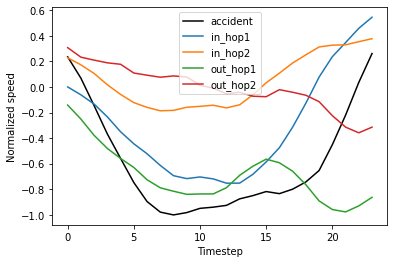

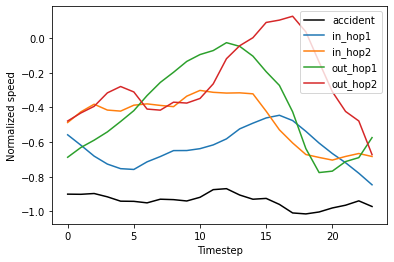

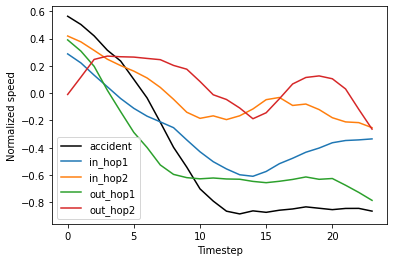

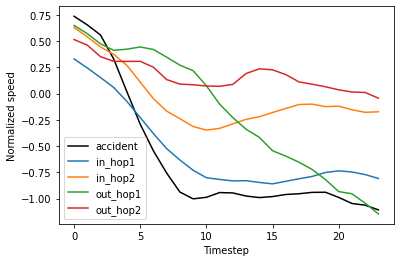

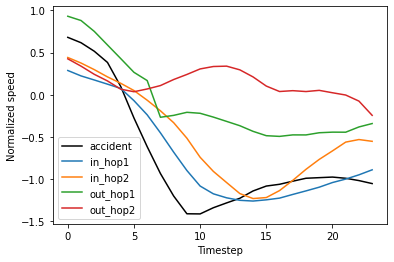

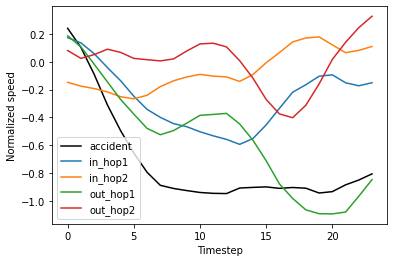

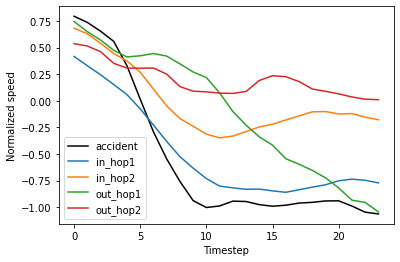

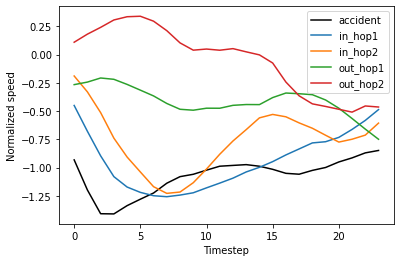

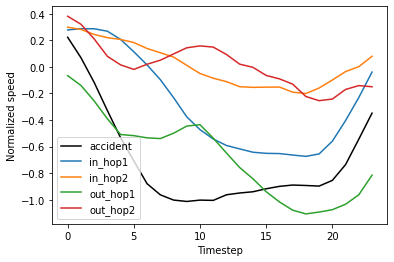

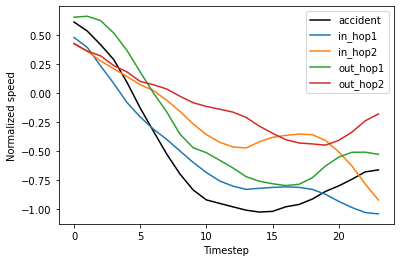

In [87]:
bs = args.batch_size
n_node = 25
for detected in tmp[:10]:
    i = detected // args.batch_size
    j = detected % args.batch_size

    for ix, data in enumerate(test_loader):
        if ix == i:
            tmp_df = pd.DataFrame(data.x[data.batch == j], index=test_df.columns.astype(int)).T
            df_agg_inflow, df_agg_outflow = speed_agg(tmp_df)


    plt.figure()
    plt.plot(df_agg_inflow[0], label='accident', color='k')
    plt.plot(df_agg_inflow[1], label='in_hop1')
    plt.plot(df_agg_inflow[2], label='in_hop2')
    plt.plot(df_agg_outflow[2], label='out_hop1')
    plt.plot(df_agg_outflow[1], label='out_hop2')
    plt.legend()
    plt.ylabel('Normalized speed')
    plt.xlabel('Timestep')
    plt.show()

In [82]:
def speed_agg(test_df):

    df_agg_inflow, df_agg_outflow = [], []
    for hop in [0, 1, 2, 3]:
        inflow = np.unique([p[hop] for p in path_inflow])
        outflow = np.unique([p[hop] for p in path_outflow])
        inflow = [p for p in inflow if p in list(test_df.columns)]
        outflow = [p for p in outflow if p in list(test_df.columns)]
        df_agg_inflow.append(test_df[inflow].mean(axis=1))
        df_agg_outflow.append(test_df[outflow].mean(axis=1))
    df_agg_inflow = pd.concat(df_agg_inflow, axis=1)
    df_agg_outflow = pd.concat(df_agg_outflow, axis=1)

    return df_agg_inflow, df_agg_outflow

### Prediction Case for true incident

In [88]:
df_agg_inflow, df_agg_outflow = [], []
for hop in [0, 1, 2, 3]:
    inflow = np.unique([p[hop] for p in path_inflow])
    outflow = np.unique([p[hop] for p in path_outflow])
    inflow = [p for p in inflow if p in list(test_df.columns)]
    outflow = [p for p in outflow if p in list(test_df.columns)]
    df_agg_inflow.append(test_df[inflow].mean(axis=1))
    df_agg_outflow.append(test_df[outflow].mean(axis=1))
df_agg_inflow = pd.concat(df_agg_inflow, axis=1)
df_agg_outflow = pd.concat(df_agg_outflow, axis=1)

In [ ]:
st_time_list = np.where(np.diff(label_all.reshape(-1), prepend=1) == 1)[0]
ed_time_list = np.where(np.diff(label_all.reshape(-1), prepend=1) == -1)[0][1:]

pred = list(map(int, [s>0 for s in score_all]))

for st, ed in zip(st_time_list, ed_time_list):
    if sum(pred[st:ed]) == 0:
        print('Not detected')
    else:
        print('Detected')
        print('MTTD = ', np.where(np.diff(pred[st:ed], prepend=1)==1)[0])

        i = st + np.where(np.diff(pred[st:ed], prepend=1)==1)[0][0]
        plt.figure()
        plt.plot(df_agg_inflow[i:i+24][0], label='accident', color='k')
        plt.plot(df_agg_inflow[i:i+24][1], label='in_hop1')
        plt.plot(df_agg_inflow[i:i+24][2], label='in_hop2')
        plt.plot(df_agg_outflow[i:i+24][2], label='out_hop1')
        plt.plot(df_agg_outflow[i:i+24][1], label='out_hop2')
        plt.legend()
        plt.show()
    

## embedding distribution plot

### Test set

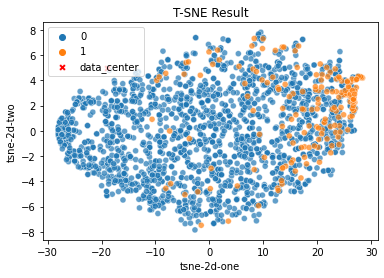

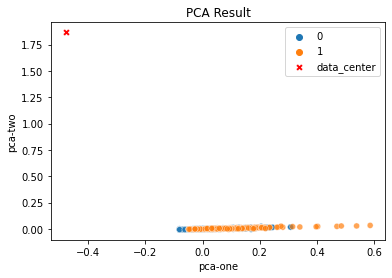

In [68]:
## test set all T-SNE
import seaborn as sns 


normal = np.where(label_all == 0)[0]
abnormal = np.where(label_all == 1)[0]

rndperm = np.random.choice(normal, 2000)

## add data center
center_arr = data_center.detach().cpu().numpy()
out_center_all = np.concatenate([np.concatenate(out_all), center_arr.reshape(1, -1)])

## tSNE
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=200)
tsne_all = tsne.fit_transform(out_center_all)

tsne_df = pd.DataFrame(tsne_all, columns=['tsne-2d-one', 'tsne-2d-two'])
tsne_df['y'] = np.append(label_all, [-1])

sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("tab10", 2),
    data=tsne_df.loc[np.append(rndperm, abnormal), :],
    legend="full",
    alpha=0.7
)
sns.scatterplot(x=tsne_df[tsne_df.y == -1]["tsne-2d-one"], y=tsne_df[tsne_df.y == -1]["tsne-2d-two"],
    color='red',
    marker='X',
    s=50,
    label='data_center'
)

plt.title('T-SNE Result')
plt.show()


## PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_all = pca.fit_transform(out_center_all)

pca_df = pd.DataFrame(pca_all, columns=['pca-one', 'pca-two'])
pca_df['y'] = np.append(label_all, [-1])

sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="y",
    palette=sns.color_palette("tab10", 2),
    data=pca_df.loc[np.append(rndperm, abnormal), :],
    legend="full",
    alpha=0.7
)
sns.scatterplot(x=pca_df[pca_df.y == -1]['pca-one'], y=pca_df[pca_df.y == -1]["pca-two"],
    color='red',
    marker='X',
    s=50,
    label='data_center'
)


plt.title('PCA Result')
plt.show()

Text(0, 0.5, 'Distance')

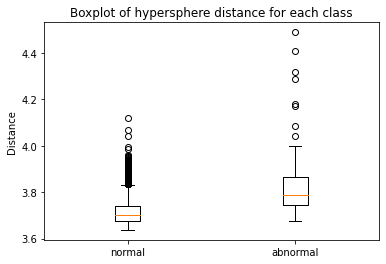

In [69]:
normal = np.where(label_all == 0)[0]
abnormal = np.where(label_all == 1)[0]

plt.boxplot([dist_all[normal], dist_all[abnormal]])
# plt.ylim(0, 1e3)
plt.xticks([1, 2],['normal', 'abnormal'])
plt.title('Boxplot of hypersphere distance for each class')
plt.ylabel('Distance')

/tmp/ipykernel_3015882/2113342768.py:2: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  sns.displot(data=dist_df, x='dist', hue='label', kind='kde', fill=True, common_norm=False, common_grid=False, palette=sns.color_palette("Set2"))


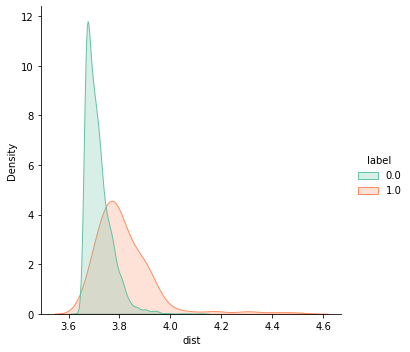

In [70]:
dist_df = pd.DataFrame([dist_all, label_all.reshape(-1)], index=['dist', 'label']).T
sns.displot(data=dist_df, x='dist', hue='label', kind='kde', fill=True, common_norm=False, common_grid=False, palette=sns.color_palette("Set2"))

### T-SNE comparison

train dataset


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7485/7485 [00:01<00:00, 4614.83it/s]


val dataset


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2269/2269 [00:00<00:00, 3316.18it/s]


test dataset


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2051/2051 [00:00<00:00, 4529.68it/s]


59 18 17
Parameter number of GCN_gc Net is: 7840
./checkpoints_SAD_mprofile/1210005301_mprofile/1210005301_mprofile_GCN_sum_0.1_True+bestcheckpoint.pt


18it [00:00, 63.86it/s]


[40.245483 31.268293 19.20501  15.966684 12.886364]


17it [00:00, 70.83it/s]


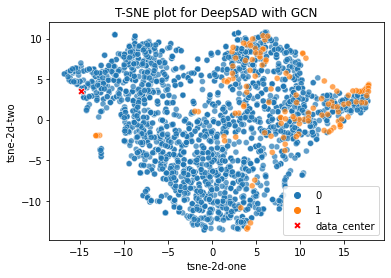

Parameter number of GAT_gc Net is: 293984
./checkpoints_SAD_mprofile/1210005301_mprofile/1210005301_mprofile_GAT_sum_0.1_True+bestcheckpoint.pt


18it [00:00, 60.71it/s]


[131.9623   115.62781   41.91107   38.258663  28.643475]


17it [00:00, 64.86it/s]


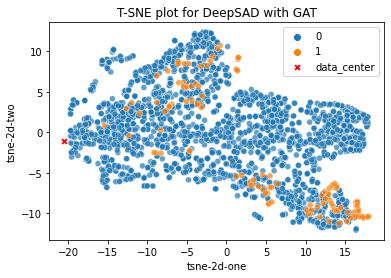

Parameter number of GraphSAGE_gc Net is: 15520
./checkpoints_SAD_mprofile/1210005301_mprofile/1210005301_mprofile_GraphSAGE_sum_0.1_True+bestcheckpoint.pt


18it [00:00, 76.91it/s]


[79.47407  78.53688  19.764284 19.854511 10.41513 ]


17it [00:00, 86.28it/s]


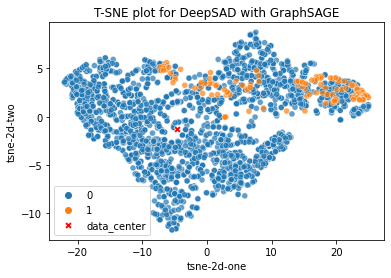

Parameter number of STGCN Net is: 4532
./checkpoints_SAD_mprofile/1210005301_mprofile/1210005301_mprofile_STGCN_sum_0.1_True+bestcheckpoint.pt


18it [00:01, 14.69it/s]


[261.5694  261.58984 259.74075 259.34268 261.29953]


17it [00:00, 17.94it/s]


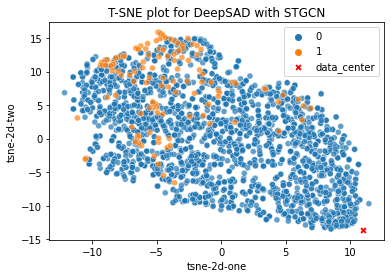

In [39]:
args.dataset = '1210005301_mprofile'
train_loader, val_loader, test_loader = traffic_mtsc_loader(args)
print(len(train_loader), len(val_loader), len(test_loader))


for module, name in zip(['GCN_gc', 'GAT_gc', 'GraphSAGE_gc', 'STGCN'], ['GCN','GAT', 'GraphSAGE', 'STGCN']):
# for module, name in zip(['GraphSAGE_gc'], ['GraphSAGE']):
    
    args.module = module
    name = name
    args.normalize = 'standard'
    args.nu = 0.10
    args.pooling = 'sum'
    args.reverse = False
    args.self_loop = 'True'
    args.bias = True

    args.exp_name = f'{args.dataset}_{name}_{args.pooling}_{args.nu}_{args.self_loop}'

    checkpoints_path=f'./checkpoints_SAD_mprofile/{args.dataset}/{args.exp_name}+bestcheckpoint.pt'
    
    input_dim = 24
    model = init_model(args, input_dim)
    print(checkpoints_path)

    model.load_state_dict(torch.load(checkpoints_path, map_location='cuda:0')['model'])
    model.to(device=f'cuda:{args.gpu}')
    model.eval()
    data_center = torch.load(checkpoints_path, map_location='cuda')['data_center']
    radius = torch.load(checkpoints_path, map_location='cuda')['radius']


    out_all, dist_all, score_all = [], [], []
    label_all = []
    for ix, data in tqdm(enumerate(val_loader)):
        output = model(data.to(device=f'cuda:{args.gpu}'))
        out_all.append(output.cpu().detach().numpy())
        label_all.append(data.y.cpu().detach().numpy())
        # dist, score = anomaly_score(data_center, output, radius)
        dist = torch.sum((output - data_center) ** 2, dim=1)
        dist_all.append(dist.cpu().detach().numpy())
    dist_all = np.concatenate(dist_all)
    print(dist_all[:5])
    # new_radius = np.quantile(np.sqrt(dist_all), 1 - args.nu)
    new_radius = np.quantile(np.sqrt(dist_all), 1 - args.nu)
    new_radius


    out_all, dist_all, score_all = [], [], []
    label_all = []
    for ix, data in tqdm(enumerate(test_loader)):
        output = model(data.to(device=f'cuda:{args.gpu}'))
        out_all.append(output.cpu().detach().numpy())
        label_all.append(data.y.cpu().detach().numpy())
    label_all = np.concatenate(label_all)

    

    ## test set all T-SNE
    import seaborn as sns 


    normal = np.where(label_all == 0)[0]
    abnormal = np.where(label_all == 1)[0]

    rndperm = np.random.choice(normal, 3000)

    ## add data center
    center_arr = data_center.detach().cpu().numpy()
    out_center_all = np.concatenate([np.concatenate(out_all), center_arr.reshape(1, -1)])

    ## tSNE
    from sklearn.manifold import TSNE

    tsne = TSNE(n_components=2, perplexity=200, random_state=0)
    tsne_all = tsne.fit_transform(out_center_all)

    tsne_df = pd.DataFrame(tsne_all, columns=['tsne-2d-one', 'tsne-2d-two'])
    tsne_df['y'] = np.append(label_all, [-1])

    sns.scatterplot(
        x="tsne-2d-one", y="tsne-2d-two",
        hue="y",
        palette=sns.color_palette("tab10", 2),
        data=tsne_df.loc[np.append(rndperm, abnormal), :],
        legend="full",
        alpha=0.7
    )
    sns.scatterplot(x=tsne_df[tsne_df.y == -1]["tsne-2d-one"], y=tsne_df[tsne_df.y == -1]["tsne-2d-two"],
        color='red',
        marker='X',
        s=50,
        label='data_center'
    )

    plt.title('T-SNE plot for DeepSAD with {}'.format(name))
    plt.show()


    

In [109]:
normal = np.where(label_all == 0)[0]
abnormal = np.where(label_all == 1)[0]

plt.boxplot([dist_all[normal], dist_all[abnormal]])
# plt.ylim(0, 1e3)
plt.xticks([1, 2],['normal', 'abnormal'])
plt.title('Boxplot of hypersphere distance for each class')
plt.ylabel('Distance')

TypeError: only integer scalar arrays can be converted to a scalar index

# All Incidents

In [27]:
out_1 = pd.read_csv('result/1210005301_mprofile_sumpool.csv', index_col=0)
out_2 = pd.read_csv('result/1030001902_mprofile_sumpool.csv', index_col=0)
out_3 = pd.read_csv('result/1220005401_mprofile_sumpool.csv', index_col=0)
out_4 = pd.read_csv('result/1210003000_mprofile_sumpool.csv', index_col=0)
out_5 = pd.read_csv('result/1130052300_mprofile_sumpool.csv', index_col=0)

In [28]:
out_1 = out_1[out_1.adjust == False]
out_2 = out_2[out_2.adjust == False]
out_3 = out_3[out_3.adjust == False]
out_4 = out_4[out_4.adjust == False]
out_5 = out_5[out_5.adjust == False]

In [29]:
tmp = np.nanmean([out_1.iloc[:, 4:], out_2.iloc[:, 4:], out_3.iloc[:,4:], out_4.iloc[:,4:], out_5.iloc[:,4:]], axis=0)
tmp = pd.DataFrame(tmp, columns=out_1.columns[4:], index=out_1.index)
out_all = pd.concat([out_1.iloc[:, :4], tmp], axis=1)
out_all

,model,normalize,nu,adjust,DR,far,precision,recall,acc,AUC,F1_macro,F1_weight,AP
0,GCN,standard,0.01,False,0.013864,0.650000,0.350000,0.013864,0.922980,0.546929,0.492935,0.908227,0.126655
2,GAT,standard,0.01,False,0.033418,0.646154,0.353846,0.033418,0.938623,0.616417,0.514543,0.918917,0.155132
4,GraphSAGE,standard,0.01,False,0.034760,0.769551,0.230449,0.034760,0.923537,0.592327,0.507307,0.910144,0.137494
6,STGCN,standard,0.01,False,0.048670,0.229870,0.770130,0.048670,0.944743,0.677966,0.530758,0.922530,0.242391
8,GCN,standard,0.05,False,0.094821,0.775363,0.224637,0.094821,0.887740,0.617423,0.524552,0.893970,0.140086
10,GAT,standard,0.05,False,0.116808,0.867405,0.132595,0.116808,0.874057,0.491533,0.521381,0.886854,0.108994
12,GraphSAGE,standard,0.05,False,0.102745,0.910679,0.089321,0.102745,0.851997,0.467849,0.497542,0.871382,0.088714
14,STGCN,standard,0.05,False,0.130538,0.629512,0.370488,0.130538,0.927164,0.699959,0.561418,0.917813,0.248946
16,GCN,standard,0.10,False,0.204323,0.870810,0.129190,0.204323,0.855912,0.614860,0.535476,0.879147,0.148371
18,GAT,standard,0.10,False,0.236609,0.834227,0.165773,0.236609,0.851362,0.528302,0.542515,0.876407,0.117744


In [30]:
out_all.to_csv('result/mprofile_out_all.csv')

In [31]:
tmp = np.nanstd([out_1.iloc[:, 4:], out_2.iloc[:, 4:], out_3.iloc[:,4:], out_4.iloc[:,4:], out_5.iloc[:,4:]], axis=0)
tmp = pd.DataFrame(tmp, columns=out_1.columns[4:], index=out_1.index)
out_all = pd.concat([out_1.iloc[:, :4], tmp], axis=1)
out_all

,model,normalize,nu,adjust,DR,far,precision,recall,acc,AUC,F1_macro,F1_weight,AP
0,GCN,standard,0.01,False,0.020770,0.435890,0.435890,0.020770,0.029469,0.171800,0.023073,0.030105,0.102022
2,GAT,standard,0.01,False,0.038315,0.370919,0.370919,0.038315,0.015818,0.104169,0.033070,0.021192,0.080703
4,GraphSAGE,standard,0.01,False,0.035722,0.386025,0.386025,0.035722,0.028615,0.154496,0.036325,0.028236,0.119037
6,STGCN,standard,0.01,False,0.026007,0.335648,0.335648,0.026007,0.021920,0.136423,0.025812,0.028781,0.137002
8,GCN,standard,0.05,False,0.063055,0.247957,0.247957,0.063055,0.060933,0.154225,0.061311,0.046852,0.098468
10,GAT,standard,0.05,False,0.088899,0.131186,0.131186,0.088899,0.064405,0.177712,0.051730,0.047917,0.083508
12,GraphSAGE,standard,0.05,False,0.087089,0.080940,0.080940,0.087089,0.088340,0.141454,0.045754,0.060321,0.064348
14,STGCN,standard,0.05,False,0.064498,0.337616,0.337616,0.064498,0.029931,0.160499,0.030952,0.028844,0.177834
16,GCN,standard,0.10,False,0.100271,0.098288,0.098288,0.100271,0.040522,0.120213,0.054917,0.031482,0.112822
18,GAT,standard,0.10,False,0.072452,0.163243,0.163243,0.072452,0.062634,0.087068,0.063751,0.047214,0.106457


In [32]:
out_all.to_csv('result/mprofile_out_std.csv')